# Machine Learning (ML)

In [1]:
import os
import sys
import numpy as np
import sklearn

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
ROOT_DIR = '.'
IMAGES_PATH = os.path.join(ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='pdf', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data
We work on MNIST dataset

In [3]:
from sklearn.datasets import fetch_openml

In [4]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [5]:
X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8)

In [6]:
print(X.shape)  # 28 * 28 = 784
print(y.shape)

(70000, 784)
(70000,)


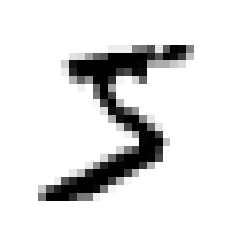

In [12]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis('off')
plt.show()

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Evaluation

In [85]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

### Cross-valication

In [48]:
from sklearn.model_selection import cross_val_score

In [52]:
from sklearn.model_selection import cross_val_predict

## Stochastic Gradient Descent (SGD)

In [63]:
from sklearn.linear_model import SGDClassifier

In [64]:
# sgd_clf = SGDClassifier()
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3)

Train SGD as binary classifier

In [65]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [66]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

Test SGD on a sample (e.g. this case digit is 5)

In [68]:
sgd_clf.predict([some_digit])

array([ True])

Observe the decision score not the final result

In [69]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2528.6763646])

Test the performance

In [49]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95735, 0.9355 , 0.9669 ])

Confusion matrix

In [54]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [56]:
confusion_matrix(y_train_5, y_train_pred)

array([[52647,  1932],
       [ 1374,  4047]])

In [58]:
precision_score(y_train_5, y_train_pred)

0.6768690416457601

In [59]:
recall_score(y_train_5, y_train_pred)

0.746541228555617

In [61]:
f1_score(y_train_5, y_train_pred)

0.71

Calculate decision functions in training (not predictions) and then the precision and recall curves

In [70]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [72]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

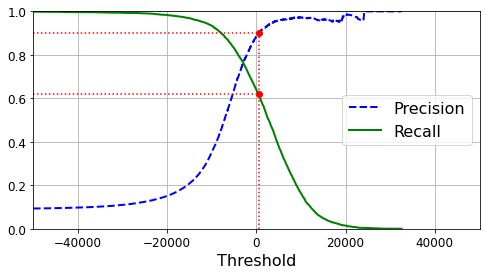

In [74]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel('Threshold', fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([threshold_90_precision], [0.9], 'ro')
plt.plot([threshold_90_precision], [recall_90_precision], 'ro')
plt.show()

Find a thrshold that gives at least 90% precision and then make prediction based on that threshold

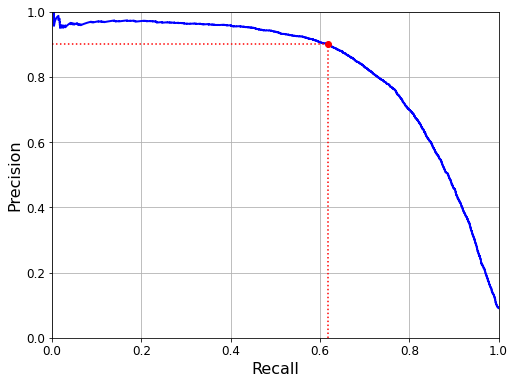

In [75]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], 'r:')
plt.plot([0.0, recall_90_precision], [0.9, 0.9], 'r:')
plt.plot([recall_90_precision], [0.9], 'ro')
plt.show()

In [77]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

479.1759298601993

In [78]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [79]:
precision_score(y_train_5, y_train_pred_90)

0.9001342281879194

In [81]:
recall_score(y_train_5, y_train_pred_90)

0.6185205681608559

ROC curve

In [83]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

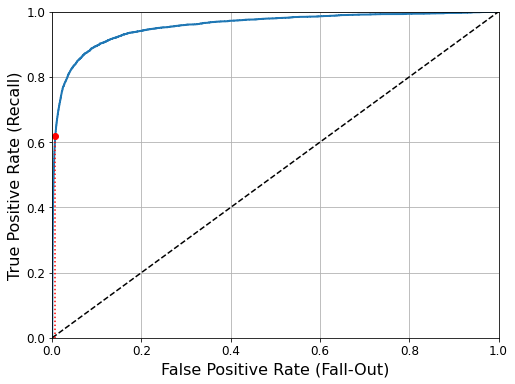

In [84]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

In [86]:
roc_auc_score(y_train_5, y_scores)

0.9569799732729027

In [87]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [88]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

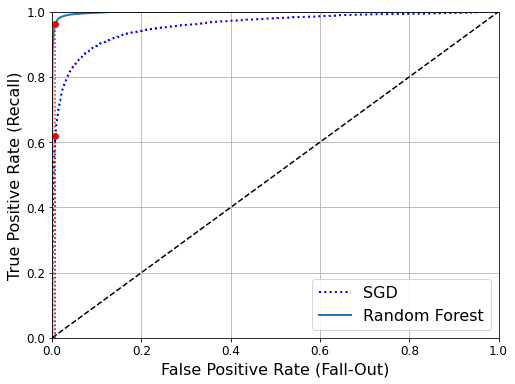

In [89]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [90]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [91]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [92]:
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [93]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

Train SGD as multiclass

In [45]:
sgd_clf.fit(X_train, y_train)

SGDClassifier()

Test SGD on a sample

In [46]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [51]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.85215, 0.8796 , 0.86055])

## Support Vector Machine (SVM)

In [8]:
from sklearn.svm import SVC

Train SVM on MNIST dataset

In [9]:
svm_clf = SVC(gamma='auto')
svm_clf.fit(X_train[:1000], y_train[:1000])

SVC(gamma='auto')

Check the classes of classifier

In [10]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Test on a sample picture (e.g. digit 5)

In [13]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Investigate all pairs of SVM scores

In [14]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

Identify the class of highest score

In [15]:
np.argmax(some_digit_scores)

5

In [17]:
svm_clf.classes_[5]

5

One-versus-One (OvO)

In [ ]:
from sklearn.multiclass import OneVsOneClassifier

One-versus-rest (OvR)

In [19]:
from sklearn.multiclass import OneVsRestClassifier

In [20]:
ovr_clf = OneVsRestClassifier(SVC(gamma='auto', random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])

OneVsRestClassifier(estimator=SVC(gamma='auto', random_state=42))

Now the number of estimators is equal to number of classes

In [23]:
len(ovr_clf.estimators_)

10

In [21]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
# Warning - the following can take a long time to run (e.g. 30 minutes)
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')